In [1]:
import joblib
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder,
    LabelEncoder, SplineTransformer, OrdinalEncoder
)
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_validate, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn import set_config

from xgboost import XGBClassifier

from IPython.display import HTML

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


set_config(display="diagram")

### Recuperendo os dados pré-processados

In [2]:
df = pd.read_csv("../data/interim/data_pre_processados.csv")
df.head()

,limite,sexo,educacao,estado_civil,idade,status_0509,status_0508,status_0507,status_0506,status_0505,...,saldo_0506,saldo_0505,saldo_0504,pago_0509,pago_0508,pago_0507,pago_0506,pago_0505,pago_0504,mau
0,20000,feminino,universidade,casado,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,sim
1,120000,feminino,universidade,solteiro,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,sim
2,90000,feminino,universidade,solteiro,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,nao
3,50000,feminino,universidade,casado,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,nao
4,50000,masculino,universidade,casado,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,nao


In [3]:
remover = df.columns[df.columns.str.startswith('status')]
df.drop(remover, axis=1, inplace=True)

### Correlações

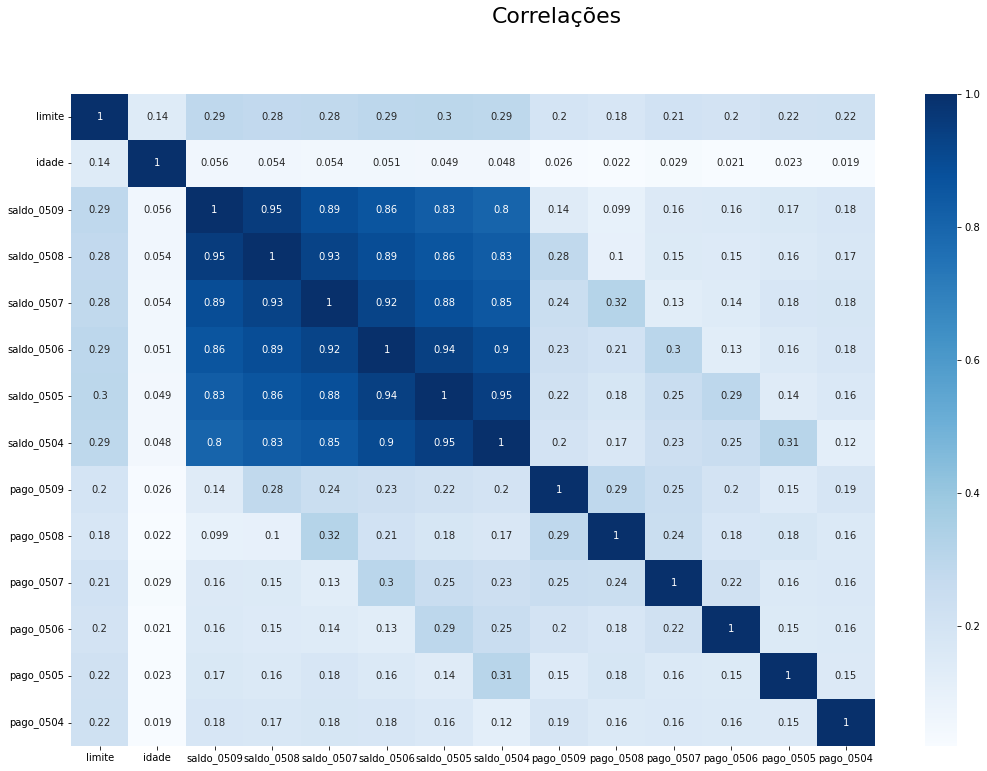

In [4]:
correl = df.corr(method='pearson')
plt.figure(figsize=(18,12))
sns.heatmap(correl, annot=True, cmap="Blues")
plt.suptitle('Correlações', fontsize=22)
plt.show()

#### Buscando os tipos do dicionário

In [5]:
df_dicionario = pd.read_csv("../references/dicionario_dados.csv")

mask = df_dicionario['Col_Trad'][df_dicionario['Tipo'] == 'num'].isin(list(df.columns))
df_dicionario['Col_Trad'][df_dicionario['Tipo'] == 'num'][mask].values

target_column = 'mau'

nominal_columns = df_dicionario['Col_Trad'][df_dicionario['Tipo'] == 'cat'].values

mask = df_dicionario['Col_Trad'][df_dicionario['Tipo'] == 'num'].isin(list(df.columns))
numerical_columns =  df_dicionario['Col_Trad'][df_dicionario['Tipo'] == 'num'][mask].values

#### Separando X e y com o conjunto completo de dados

In [7]:
X = df.drop([target_column], axis=1)

target_transformer = LabelEncoder()

y = target_transformer.fit_transform(df[target_column].values.ravel())

#### Primeiro teste

In [37]:
preprocessor = ColumnTransformer([
    ("one-hot-encoding", OneHotEncoder(), nominal_columns),
    ("scaler", StandardScaler(), numerical_columns)
])

In [38]:
models = {
    'logistic-regression': LogisticRegression(solver='lbfgs', max_iter=3000),
    'KNN': KNeighborsClassifier(weights= "uniform",algorithm="brute", leaf_size=2,n_neighbors=50),
    'SVM': SVC(gamma='auto'),
    'gradient-boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0),
    'Random Forest': RandomForestClassifier(random_state=0),
    'Percéptron Multi-Camadas': MLPClassifier(random_state=0, activation='relu', solver='adam', learning_rate='adaptive', max_iter=200),
    'XGBoost': XGBClassifier(n_estimators=200, verbosity=0, use_label_encoder=False, random_state=0, max_depth= 5,gamma= 2)
}

In [39]:
%%time
results = {}
n_splits = 30
for model_name, model in tqdm(models.items()):
    scores = cross_validate(
        estimator = Pipeline(steps=[
            ("preprocessamento", preprocessor),
            ("modelo", model)
        ]),
        X = X,
        y = y,
        cv = ShuffleSplit(n_splits=n_splits, test_size=.2),
        n_jobs = 4,
        scoring = ['accuracy','f1', 'precision', 'recall', 'roc_auc']
    )
    scores['model'] = [model_name] * n_splits
    if not(results):
        results = scores
    else:
        for key in results:
            results[key] = list(results[key])
            results[key].extend(scores[key])

  0%|          | 0/7 [00:00<?, ?it/s]

CPU times: user 1.88 s, sys: 177 ms, total: 2.06 s
Wall time: 16min 22s


/home/vilquer/.cache/pypoetry/virtualenvs/src-adCLVQQ5-py3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vilquer/.cache/pypoetry/virtualenvs/src-adCLVQQ5-py3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vilquer/.cache/pypoetry/virtualenvs/src-adCLVQQ5-py3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

In [40]:
resultados = pd.DataFrame(results).groupby('model').agg([np.mean, np.std]).transpose()
resultados.style.background_gradient(cmap='Blues', axis=1)

#### Segundo teste

In [41]:
nominal_preprocessing = Pipeline([    
    ("missing", SimpleImputer(strategy='most_frequent')),
    ("encoder", OneHotEncoder())
])
quantitative_preprocessing = Pipeline([
    ("missing", SimpleImputer()),
    ("scaler", StandardScaler())
])
preprocessing = ColumnTransformer([
    ("nominal", nominal_preprocessing, nominal_columns),
    ("quantitative", quantitative_preprocessing, numerical_columns)
])

In [42]:
models = {
    'knn': KNeighborsClassifier(),
    'Percéptron Multi-Camadas': MLPClassifier(random_state=0),
    'logistic regression': LogisticRegression(max_iter=3000),
    'XGBoost': XGBClassifier(n_estimators=200, verbosity=0, use_label_encoder=False, random_state=0),
    'Random Forest': RandomForestClassifier(random_state=0)
}
params = {
    'knn': {
        'weights': ['uniform', 'distance'],
        'algorithm': ['ball_tree', 'kd_tree', 'brute'],
        'leaf_size': [1, 2],
        'n_neighbors': [5, 15,]
    },
    'Percéptron Multi-Camadas':{
        #'hidden_layer_sizes': [(100,), (100, 100), (200,), (200, 200), (500, 500)],
        'activation': ['tanh', 'relu'],
        'learning_rate': ['constant','adaptive']
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],
         'criterion': ['entropy', 'gini']
    },
    'XGBoost': {
        'max_depth': [4, 5,7,10],
        'gamma': [0.5, 2, 5,7,10]  
    },
    'logistic regression': {
        'C': [1, 10, 100],
        'max_iter': [50, 100, 150, 200],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    }
}

In [43]:
results = {}
n_splits = 5
for model_name, model in tqdm(models.items()):
    
    param_grid = {
        'preprocessing__quantitative__missing__strategy': ['mean', 'median'],
        **{f"model__{key}": value for key, value in params[model_name].items()}
    }
    approach = Pipeline([
        ('preprocessing', preprocessing),
        ('model', model)
    ])
    gs = GridSearchCV(
        estimator=approach,
        param_grid=param_grid,
        scoring='accuracy',
        cv=5
    )
    scores = cross_validate(
        estimator = gs,
        X=X,
        y=y,
        cv = ShuffleSplit(n_splits=n_splits, test_size=.2),
        n_jobs = -1,
        verbose = 20,
        scoring = ['accuracy', 'precision', 'recall','f1', 'roc_auc']
    )
    scores['model'] = [model_name] * n_splits
    if not(results):
        results = scores
    else:
        for key in results:
            results[key] = list(results[key])
            results[key].extend(scores[key])

  0%|          | 0/5 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 26.6min
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 26.7min remaining: 40.1min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed: 26.9min remaining: 17.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 26.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 26.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/vilquer/.cache/pypoetry/virtualenvs/src-adCLVQQ5-py3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/vilquer/.cache/pypoetry/virtualenvs/src-adCLVQQ5-py3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum i

In [25]:
resultados = pd.DataFrame(results).groupby('model').agg([np.mean, np.std])
resultados.style.background_gradient(cmap='Blues', axis=0)

In [60]:
results = {}
n_splits = 5
for model_name, model in tqdm(models.items()):
    
    param_grid = {
        'preprocessing__quantitative__missing__strategy': ['mean', 'median'],
        **{f"model__{key}": value for key, value in params[model_name].items()}
    }
    approach = Pipeline([
        ('preprocessing', preprocessing),
        ('model', model)
    ])
    gs = GridSearchCV(
        estimator=approach,
        param_grid=param_grid,
        scoring='accuracy',
        cv=5
    )
    scores = cross_validate(
        estimator = gs,
        X=X,
        y=y,
        cv = ShuffleSplit(n_splits=n_splits, test_size=.2),
        n_jobs = 4,
        verbose = 20,
        scoring = ['accuracy', 'precision', 'recall','f1', 'roc_auc']
    )
    scores['model'] = [model_name] * n_splits
    if not(results):
        results = scores
    else:
        for key in results:
            results[key] = list(results[key])
            results[key].extend(scores[key])

  0%|          | 0/5 [00:00<?, ?it/s]

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed: 23.8min
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed: 23.9min remaining: 35.9min
[Parallel(n_jobs=4)]: Done   3 out of   5 | elapsed: 24.0min remaining: 16.0min


[CV] START .....................................................................
[CV] END  accuracy: (test=0.763) f1: (test=0.094) precision: (test=0.341) recall: (test=0.055) roc_auc: (test=0.625) total time=23.9min
[CV] START .....................................................................
[CV] END  accuracy: (test=0.768) f1: (test=0.104) precision: (test=0.346) recall: (test=0.061) roc_auc: (test=0.613) total time=24.0min
[CV] START .....................................................................
[CV] END  accuracy: (test=0.764) f1: (test=0.102) precision: (test=0.379) recall: (test=0.059) roc_auc: (test=0.619) total time=24.0min


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed: 37.9min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed: 37.9min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/home/vilquer/.cache/pypoetry/virtualenvs/src-adCLVQQ5-py3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/vilquer/.cache/pypoetry/virtualenvs/src-adCLVQQ5-py3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/vilquer/.cache/pypoetry/virtualenvs/src-adCLVQQ5-py3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached a

[CV] START .....................................................................
[CV] END  accuracy: (test=0.783) f1: (test=0.269) precision: (test=0.497) recall: (test=0.184) roc_auc: (test=0.711) total time=24.6min
[CV] START .....................................................................
[CV] END  accuracy: (test=0.784) f1: (test=0.207) precision: (test=0.589) recall: (test=0.126) roc_auc: (test=0.716) total time=24.7min


/home/vilquer/.cache/pypoetry/virtualenvs/src-adCLVQQ5-py3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/vilquer/.cache/pypoetry/virtualenvs/src-adCLVQQ5-py3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/vilquer/.cache/pypoetry/virtualenvs/src-adCLVQQ5-py3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/vilquer/.cache/pypoetry/virtualenvs/src-adCLVQQ5-py3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Sto

[CV] START .....................................................................
[CV] END  accuracy: (test=0.777) f1: (test=0.183) precision: (test=0.547) recall: (test=0.110) roc_auc: (test=0.705) total time=25.3min


/home/vilquer/.cache/pypoetry/virtualenvs/src-adCLVQQ5-py3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/vilquer/.cache/pypoetry/virtualenvs/src-adCLVQQ5-py3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/vilquer/.cache/pypoetry/virtualenvs/src-adCLVQQ5-py3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/vilquer/.cache/pypoetry/virtualenvs/src-adCLVQQ5-py3.8/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Sto

[CV] START .....................................................................
[CV] END  accuracy: (test=0.768) f1: (test=0.113) precision: (test=0.357) recall: (test=0.067) roc_auc: (test=0.620) total time=23.8min
[CV] START .....................................................................
[CV] END  accuracy: (test=0.773) f1: (test=0.140) precision: (test=0.389) recall: (test=0.085) roc_auc: (test=0.626) total time=14.1min
[CV] START .....................................................................
[CV] END  accuracy: (test=0.781) f1: (test=0.201) precision: (test=0.546) recall: (test=0.124) roc_auc: (test=0.714) total time=23.9min
[CV] START .....................................................................
[CV] END  accuracy: (test=0.783) f1: (test=0.160) precision: (test=0.551) recall: (test=0.094) roc_auc: (test=0.709) total time=11.9min
[CV] START .....................................................................
[CV] END  accuracy: (test=0.775) f1: (test=0.001) p

/home/vilquer/.cache/pypoetry/virtualenvs/src-adCLVQQ5-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/vilquer/.cache/pypoetry/virtualenvs/src-adCLVQQ5-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/vilquer/.cache/pypoetry/virtualenvs/src-adCLVQQ5-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/vilquer/.cache/pypoetry/virtualenvs/src-adCLVQQ5-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/vilquer/.cache/pypoetry/virtualenvs/src-adCLVQQ5-py3.8/lib/python3.8/site-packages/sklearn/linear_

[CV] START .....................................................................
[CV] END  accuracy: (test=0.778) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.674) total time= 7.4min
[CV] START .....................................................................
[CV] END  accuracy: (test=0.795) f1: (test=0.280) precision: (test=0.584) recall: (test=0.184) roc_auc: (test=0.741) total time=30.6min


/home/vilquer/.cache/pypoetry/virtualenvs/src-adCLVQQ5-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/vilquer/.cache/pypoetry/virtualenvs/src-adCLVQQ5-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/vilquer/.cache/pypoetry/virtualenvs/src-adCLVQQ5-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/vilquer/.cache/pypoetry/virtualenvs/src-adCLVQQ5-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/vilquer/.cache/pypoetry/virtualenvs/src-adCLVQQ5-py3.8/lib/python3.8/site-packages/sklearn/linear_

[CV] START .....................................................................
[CV] END  accuracy: (test=0.774) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.667) total time= 7.4min
[CV] START .....................................................................
[CV] END  accuracy: (test=0.792) f1: (test=0.277) precision: (test=0.561) recall: (test=0.184) roc_auc: (test=0.721) total time=30.6min


/home/vilquer/.cache/pypoetry/virtualenvs/src-adCLVQQ5-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/vilquer/.cache/pypoetry/virtualenvs/src-adCLVQQ5-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/vilquer/.cache/pypoetry/virtualenvs/src-adCLVQQ5-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/vilquer/.cache/pypoetry/virtualenvs/src-adCLVQQ5-py3.8/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/vilquer/.cache/pypoetry/virtualenvs/src-adCLVQQ5-py3.8/lib/python3.8/site-packages/sklearn/linear_

[CV] START .....................................................................
[CV] END  accuracy: (test=0.783) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.659) total time= 7.3min
[CV] START .....................................................................
[CV] END  accuracy: (test=0.781) f1: (test=0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.672) total time= 3.6min
[CV] START .....................................................................
[CV] END  accuracy: (test=0.785) f1: (test=0.268) precision: (test=0.640) recall: (test=0.170) roc_auc: (test=0.738) total time=30.3min
[CV] START .....................................................................
[CV] END  accuracy: (test=0.786) f1: (test=0.258) precision: (test=0.584) recall: (test=0.165) roc_auc: (test=0.733) total time=14.2min
[CV] START .....................................................................
[CV] END  accuracy: (test=0.783) f1: (test=0.281) p

/home/vilquer/.cache/pypoetry/virtualenvs/src-adCLVQQ5-py3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV] START .....................................................................
[CV] END  accuracy: (test=0.786) f1: (test=0.274) precision: (test=0.523) recall: (test=0.185) roc_auc: (test=0.714) total time=12.0min
[CV] START .....................................................................
[CV] END  accuracy: (test=0.787) f1: (test=0.294) precision: (test=0.572) recall: (test=0.197) roc_auc: (test=0.724) total time=12.0min


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed: 20.1min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed: 20.1min finished


In [61]:
resultados = pd.DataFrame(results).groupby('model').agg([np.mean, np.std])
resultados.style.background_gradient(cmap='Blues', axis=0)

In [62]:
def highlight_max(s, props=''):
    values = [float(value.split()[0]) for value in s.values[1:]]
    result = [''] * len(s.values)
    if s.values[0].endswith('time'):
        result[np.argmin(values)+1] = props
    else:
        result[np.argmax(values)+1] = props
    return result

def get_winner(s):
    metric = s.values[0]
    values = [float(value.split()[0]) for value in s.values[1:]]
    models = results.columns[1:]
    
    if s.values[0].endswith('time'):
        return models[np.argmin(values)]
    else:
        return models[np.argmax(values)]

results = (
    pd
    .DataFrame(results)
    .groupby(['model'])
    .agg([lambda x: f"{np.mean(x):.3f} ± {np.std(x):.3f}"])#
    .transpose()
    .reset_index()
    .rename(columns={"level_0": "score"})
    .drop(columns="level_1")
    # .set_index('score')
)
time_scores = ['fit_time', 'score_time']
winner = results.query('score not in @time_scores').apply(get_winner, axis=1).value_counts().index[0]
results.columns.name = ''
results = (
    results
    .style
    .hide(axis='index')
    .apply(highlight_max, props='color:white;background-color:gray', axis=1)
)
display(results)
display(HTML(f'<h3> O melhor modelo é o : <span style="color:red">{winner}</span></h3>'))


score,Percéptron Multi-Camadas,Random Forest,XGBoost,knn,logistic regression
fit_time,1323.841 ± 305.720,671.715 ± 90.435,1634.008 ± 390.167,1302.027 ± 231.662,396.757 ± 89.259
score_time,0.068 ± 0.018,0.996 ± 0.285,0.055 ± 0.015,15.525 ± 6.138,0.038 ± 0.010
test_accuracy,0.782 ± 0.002,0.785 ± 0.002,0.791 ± 0.004,0.767 ± 0.003,0.778 ± 0.003
test_precision,0.546 ± 0.029,0.559 ± 0.019,0.588 ± 0.027,0.363 ± 0.019,0.200 ± 0.400
test_recall,0.127 ± 0.031,0.188 ± 0.007,0.182 ± 0.015,0.066 ± 0.011,0.000 ± 0.000
test_f1,0.204 ± 0.036,0.281 ± 0.009,0.278 ± 0.016,0.111 ± 0.016,0.000 ± 0.001
test_roc_auc,0.711 ± 0.004,0.721 ± 0.006,0.733 ± 0.007,0.621 ± 0.005,0.668 ± 0.005


In [63]:
best_model = winner
model = models[best_model]

n_splits_cv_gs = 30

param_grid = {
    'preprocessing__quantitative__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
    'preprocessing__nominal__encoder': [OneHotEncoder(sparse=False), OrdinalEncoder()],
    'preprocessing__quantitative__missing__strategy': ['mean', 'median'],
    **{f"model__{key}": value for key, value in params[model_name].items()}
}

approach = Pipeline([
    ('preprocessing', preprocessing),
    ('model', model)
])

gs = RandomizedSearchCV(
    estimator=approach,
    param_distributions=param_grid,
    scoring='accuracy',
    cv=n_splits_cv_gs,
    random_state=42
)

gs.fit(X, y)

model = gs.best_estimator_
joblib.dump(model, '../models/best_model.joblib')

[CV] START .....................................................................
[CV] END  accuracy: (test=0.786) f1: (test=0.289) precision: (test=0.570) recall: (test=0.193) roc_auc: (test=0.723) total time=11.9min
[CV] START .....................................................................
[CV] END  accuracy: (test=0.783) f1: (test=0.270) precision: (test=0.570) recall: (test=0.176) roc_auc: (test=0.731) total time= 8.2min


['../models/best_model.joblib']

In [64]:
gs.best_params_

{'preprocessing__quantitative__scaler': StandardScaler(),
 'preprocessing__quantitative__missing__strategy': 'mean',
 'preprocessing__nominal__encoder': OneHotEncoder(sparse=False),
 'model__n_estimators': 100,
 'model__criterion': 'entropy'}

In [65]:
model

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('nominal',
                                                  Pipeline(steps=[('missing',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(sparse=False))]),
                                                  array(['sexo', 'educacao', 'estado_civil'], dtype=object)),
                                                 ('quantitative',
                                                  Pipeline(steps=[('missing',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  array(['limite', 'i...
                               enable_categorical=False, eval_metric=None,
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=100, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=0, reg_alpha=0, ...))])

In [66]:
X.columns

Index(['limite', 'sexo', 'educacao', 'estado_civil', 'idade', 'saldo_0509',
       'saldo_0508', 'saldo_0507', 'saldo_0506', 'saldo_0505', 'saldo_0504',
       'pago_0509', 'pago_0508', 'pago_0507', 'pago_0506', 'pago_0505',
       'pago_0504'],
      dtype='object')